In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i for i, s in enumerate(chars, start=1)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [6]:
block_size = 3
X, Y = [], []

for w in words:
    # print(w)

    context = [0] * block_size

    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
X.shape

torch.Size([228146, 3])

In [8]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [9]:
C = torch.randn((27, 2))
C

tensor([[-7.8476e-01, -5.2322e-01],
        [ 4.3146e-01, -8.1949e-01],
        [-3.4106e-01,  1.2692e+00],
        [ 6.5745e-01, -1.0904e+00],
        [ 1.3890e-01, -7.7322e-03],
        [ 8.9317e-01,  1.3317e-01],
        [ 3.8750e-01, -2.3807e-01],
        [ 3.4467e-01,  1.6502e+00],
        [ 9.7169e-01,  6.4865e-01],
        [-4.8991e-01, -5.7690e-01],
        [-1.0355e-01,  9.2436e-02],
        [ 8.5340e-02, -1.4243e+00],
        [ 5.4150e-01,  5.7651e-01],
        [-1.2505e-01, -3.7635e-01],
        [-1.8838e+00,  3.4992e-01],
        [-1.3078e+00, -2.1458e+00],
        [ 2.0244e+00, -1.2897e+00],
        [-2.1126e+00, -1.1949e+00],
        [-1.1552e-01, -4.0751e-01],
        [-5.8859e-01,  1.9661e+00],
        [ 4.1660e-01,  1.8497e-01],
        [ 7.2866e-01,  1.0399e+00],
        [-1.0343e+00,  4.8286e-01],
        [ 7.6442e-01,  8.0979e-01],
        [-9.1793e-01, -1.3979e-01],
        [ 1.3004e+00,  4.6113e-04],
        [-7.7028e-01,  1.8972e+00]])

In [10]:
C[5]

tensor([0.8932, 0.1332])

In [11]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([0.8932, 0.1332])

In [12]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [13]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [14]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [15]:
h.shape

torch.Size([228146, 100])

In [16]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [17]:
logits = h @ W2 + b2

In [18]:
logits.shape

torch.Size([228146, 27])

In [19]:
counts = logits.exp()

In [20]:
probs = counts / counts.sum(1, keepdim=True)

In [21]:
probs.shape

torch.Size([228146, 27])

In [22]:
# now made respectable

In [23]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.rand((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [24]:
sum(p.nelement() for p in parameters)

3481

In [25]:
for p in parameters:
    p.requires_grad = True

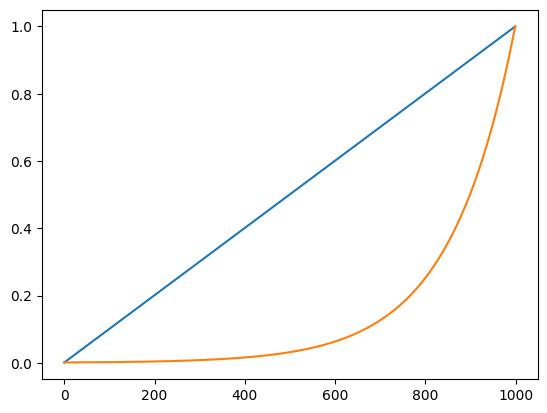

In [26]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
plt.plot(torch.linspace(0.001, 1, 1000))
plt.plot(lrs)

In [27]:
lri = []
lossi = []

for i in range(1000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))

    # forward pass
    emb = C[X[ix]] # (n, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 # (n, 27)
    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdim=True)
    # loss = -probs[torch.arange(probs.shape[0]), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())

    # backward
    for p in parameters:
        p.grad = None

    loss.backward()
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    lri.append(lre[i])
    lossi.append(loss.item())
# print(f'{loss=}')

6.675045013427734
5.923182010650635
6.106979846954346
6.479905605316162
6.60999870300293
5.716191291809082
6.842139720916748
6.3516950607299805
6.199006080627441
6.790145397186279
6.081985950469971
6.166603088378906
6.367101192474365
6.965446472167969
6.3761796951293945
6.274717807769775
6.3299713134765625
5.427406311035156
6.535934925079346
6.088397026062012
7.035577297210693
6.57722282409668
6.146029949188232
6.831775188446045
6.850090503692627
5.91618013381958
5.9671950340271
6.809368133544922
7.077219009399414
5.7838592529296875
5.736340045928955
5.252056121826172
6.657636642456055
6.312131404876709
5.963863372802734
5.994694232940674
6.672604560852051
5.978106498718262
5.945066928863525
6.14840030670166
5.264751434326172
5.968659400939941
6.3563642501831055
6.417940616607666
5.9376420974731445
5.605935573577881
5.3600616455078125
5.50945520401001
6.634702205657959
5.3661980628967285
5.538980484008789
5.983485698699951
5.399348735809326
5.831747055053711
6.068185806274414
5.8795518

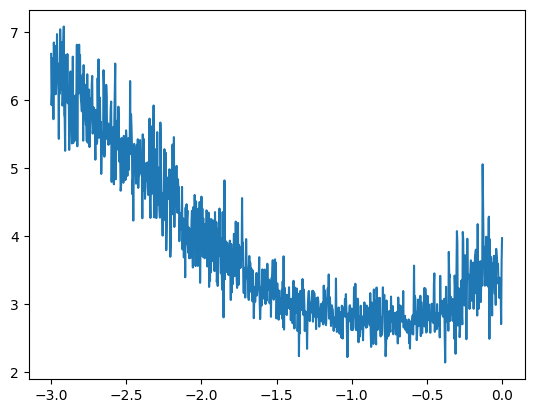

In [28]:
plt.plot(lri, lossi);